In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
import seaborn as sb
import scanpy as sc
import itertools
import gspread
import celltypist

from httplib2 import Http
from apiclient.discovery import build
from oauth2client.service_account import ServiceAccountCredentials
from scipy.stats import zscore
from matplotlib.pyplot import rc_context
from tqdm import tqdm
from math import hypot
from matplotlib.collections import LineCollection
from IPython.display import set_matplotlib_formats
from collections import Counter
from itertools import combinations
from kneed import KneeLocator
import metacells as mc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')  # low dpi (dots per inch) yields small inline figures

/home/orimosko/.local/lib/python3.8/site-packages/pynndescent/utils.py:202: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(
/home/orimosko/.local/lib/python3.8/site-packages/pynndescent/utils.py:302: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(


scanpy==1.9.8 anndata==0.9.2 umap==0.5.6 numpy==1.24.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.10.1 pynndescent==0.5.4


In [2]:
SPREADSHEET_ID = "1M4EdSuoEF1vCFF6KPgTzMnoytimIJ583v4kVL0_OpuA"
RANGE_NAME = "Sheet1"
CREDS_PATH = '/home/orimosko/credentials.json'
DROP_COLS = ["Tapestation mean peak", "QBit ng/ul", "QC1", "QC2", "FACS machine", "PCR num cycles", 
             "RT_primer concentration", "Pool barcode number", "R1 length", "R2 design"]


def load_sheet(spreadsheet_id, range_name):
    scope = 'https://www.googleapis.com/auth/spreadsheets.readonly'
    creds = ServiceAccountCredentials.from_json_keyfile_name(CREDS_PATH, scope)
    service = build('sheets', 'v4', http=creds.authorize(Http()))
    gsheet = service.spreadsheets().values().get(spreadsheetId=spreadsheet_id, range=range_name).execute()
    header = gsheet.get('values', [])[0]
    values = gsheet.get('values', [])[1:]
    all_data = []
    for col_id, col_name in enumerate(header):
        column_data = []
        for row in values:
            try:
                column_data.append(row[col_id])
            except IndexError:
                column_data.append("")
        ds = pd.Series(data=column_data, name=col_name)
        all_data.append(ds)
    df = pd.concat(all_data, axis=1)
    return df

metadata_df = load_sheet(SPREADSHEET_ID, RANGE_NAME)
metadata_df.drop(columns=DROP_COLS, inplace=True)
metadata_df.set_index("Amp.Batch.ID", inplace=True)

file_cache is only supported with oauth2client<4.0.0
Attempting refresh to obtain initial access_token
Refreshing access_token


In [3]:
cell_barcode_df = pd.read_csv("/mc_disk2/data/ori_backup/Projects/MCLab/preprocessing/OLD_barcode_list.csv")
old_barcode_dict = dict(zip(cell_barcode_df["cell_barcode"], cell_barcode_df["well_position"]))
cell_barcode_df = pd.read_csv("/mc_disk2/data/ori_backup/Projects/MCLab/preprocessing/cell_barcode_list.csv")
barcode_dict = dict(zip(cell_barcode_df["cell_barcode"], cell_barcode_df["well_position"]))
del(cell_barcode_df)

In [4]:
file_list = []
ampbatches = []
top_dir = "/mc_disk2/data/counts/"
for sub_dir in os.listdir(top_dir):
    file_dir = os.path.join(top_dir, sub_dir)
    if os.path.isdir(file_dir) and sub_dir[:2] == "SB":
        for f in os.listdir(file_dir):
            if f[-7:] == ".tsv.gz":
                file_list.append(os.path.join(file_dir, f))
                ampbatches.append(f.split("_")[0])

In [5]:
cond = [metadata_df.loc[ab, "Owner"] == "Sandra" and
        metadata_df.loc[ab, "Species"] == "Mouse" and
        metadata_df.loc[ab, "Treatment"] == "" and
        metadata_df.loc[ab, 'Strain'] != "Balbc" and
        metadata_df.loc[ab, "Tissue"] in ["", "mammary gland", "Peripheral blood", "peripheral blood"] and
        metadata_df.loc[ab, "Cell_type"] in ["CD45+", "LY6G"] and
        #not "ctc" in metadata_df.loc[ab, "Batch.Set.ID"] and
        ab != "AB433" for ab in ampbatches]

In [6]:
file_list = np.array(file_list)[cond]
ampbatches = np.array(ampbatches)[cond]

In [7]:
metadata_df = metadata_df.loc[ampbatches]
for col in metadata_df.columns:
    if np.all(metadata_df[col] == ""):
        metadata_df.drop(columns=col, inplace=True)

In [8]:
for i in tqdm(range(len(file_list))):
    f = file_list[i]
    ab = ampbatches[i]
    if not ab in f:
        raise ValueError("File to AB mismatch!! Critical")
    plate_ad = sc.read_umi_tools(f)
    plate_ad.obs["Amp.Batch.ID"] = ab
    if "old_breast" in f or "SB001" in f:
        plate_ad.obs["Well_position"] = [old_barcode_dict[x] for x in plate_ad.obs_names]
    else:
        plate_ad.obs["Well_position"] = [barcode_dict[x] for x in plate_ad.obs_names]
    plate_ad.obs_names = [ab + "_" + pos for pos in plate_ad.obs["Well_position"]]
    df_row = metadata_df.loc[ab]
    for col, val in df_row.items():
        if col not in ["Wells", "Empty wells"]:
            plate_ad.obs[col] = val.replace(" ", "")
        elif col == "Wells":
            if val != "ALL":
                raise ValueError("Ori hasn't prepared for this yet! Call him")
        elif col == "Empty wells":
                empty_wells = []
                for part in val.split(","):
                    if len(part) == 1:
                        empty_wells += [part + str(num) for num in range(1,25)]
                    elif part[1] == "-":
                        for letter in range(ord(part[0]), ord(part[2]) + 1):
                            empty_wells += [chr(letter) + str(num) for num in range(1,25)]
                    else:
                        empty_wells += [part[0] + str(i) 
                                        for i in range(int(part[1:].split("-")[0]), int(part.split("-")[1]) + 1)]
                plate_ad.obs["Empty_well"] = np.isin(plate_ad.obs.Well_position, empty_wells)
    if i == 0:
        adata = plate_ad
    else:
        adata = ad.concat([adata, plate_ad], join="outer", fill_value=0)

100%|██████████| 101/101 [00:17<00:00,  5.66it/s]


In [9]:
adata.obs.Tissue = ["Mammary Gland" if t in ["", "mammarygland"] else "Peripheral Blood" for t in adata.obs.Tissue]

In [10]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [11]:
adata.shape

(38612, 30804)

In [12]:
neut_annots = pd.read_csv("annotations/neutrophil_annots_manual.csv").set_index('cell')

In [13]:
neut_annots

mc        annot
cell                      
AB525_C6   14         TAN2
AB525_G24  15         TAN1
AB525_A2   15         TAN1
AB525_E19  15         TAN1
AB525_F2    5  Neut Ptgs2+
...        ..          ...
AB863_A18  15         TAN1
AB863_J12  12    Young TAN
AB863_C11   3  Neut Ptgs2+
AB863_J20  16         TAN1
AB863_F16  14         TAN2

[1759 rows x 2 columns]

In [14]:
tumor_adata = adata[adata.obs_names.isin(neut_annots.index)]

In [15]:
tumor_adata.shape

(1759, 30804)

In [18]:
blood_adata = adata[adata.obs.Tissue == "Peripheral Blood"]

In [19]:
blood_adata.shape

(4052, 30804)

In [20]:
[g for g in blood_adata.var_names if g[:2] == "Hb"]

['Hba-a1',
 'Hba-a2',
 'Hba-ps4',
 'Hba-x',
 'Hbb-bh1',
 'Hbb-bs',
 'Hbb-bt',
 'Hbb-y',
 'Hbegf',
 'Hbp1',
 'Hbq1a',
 'Hbs1l']

In [21]:
hb_genes = ['Hba-a1',
            'Hba-a2',
            'Hba-ps4',
            'Hba-x',
            'Hbb-bh1',
            'Hbb-bs',
            'Hbb-bt',
            'Hbb-y',
            'Hbq1a']

In [22]:
hb_sums = blood_adata[:,hb_genes].X.sum(axis=1).A1
for i in range(10):
    print(i, sum(hb_sums > i), round(100 * sum(hb_sums > i) / blood_adata.shape[0], 2))

0 399 9.85
1 156 3.85
2 91 2.25
3 57 1.41
4 40 0.99
5 36 0.89
6 32 0.79
7 30 0.74
8 28 0.69
9 27 0.67


In [23]:
blood_adata = blood_adata[hb_sums < 3]

In [24]:
blood_adata.shape

(3961, 30804)

In [25]:
non_neutrophil_genes = ["C1qa", "C1qb", "C1qc", "Itgax", "Clec10a", "Mrc1", "Tmem176b", "H2-DMa", "Ly86", "Apoe",
                        "Cd3g", "Cd3e", "Cd3d", "Trbc2", "Trac", "Trdc", "Thy1", "Cd8b1", "Cd8a", 
                        "Pecam1", "Sparc", "Dcn", "Cav1", 
                        "Col1a1", "Col9a1", "Col14a1", "Col3a1", "Col4a1", 
                        "Krt18", "Csn2", "Csn3", "Lalba", "Epcam", "Wfdc18"]

In [26]:
non_neutrophil_genes = np.array(non_neutrophil_genes)[np.isin(non_neutrophil_genes, blood_adata.var_names)]

In [27]:
pd.Index(blood_adata[:, non_neutrophil_genes].X.sum(axis=1).A1).value_counts()

0     2716
1      572
2      216
3      149
4       93
5       56
6       48
7       33
8       25
9       20
10      13
11       6
14       5
24       2
30       1
37       1
28       1
54       1
12       1
48       1
19       1
Name: count, dtype: int64

In [28]:
blood_adata = blood_adata[blood_adata[:, non_neutrophil_genes].X.sum(axis=1) < 3]

In [29]:
blood_adata.shape

(3504, 30804)

In [30]:
bdata = blood_adata.copy()

In [31]:
sc.pp.filter_cells(bdata, min_counts=100)
sc.pp.filter_cells(bdata, max_counts=6000)

filtered out 555 cells that have less than 100 counts


In [32]:
bdata = bdata[bdata.obs.pct_counts_mt < 30]

In [33]:
sc.pp.normalize_total(bdata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [34]:
sc.pp.log1p(bdata)

In [35]:
sc.pp.highly_variable_genes(bdata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [36]:
sc.pp.pca(bdata, use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [37]:
sc.pp.neighbors(bdata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [38]:
sc.tl.umap(bdata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


In [39]:
sc.tl.leiden(bdata, resolution=0.1)

running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'Amp.Batch.ID' as categorical
... storing 'Well_position' as categorical
... storing 'Seq.Batch.ID' as categorical
... storing 'Date of sequencing' as categorical
... storing 'Batch.Set.ID' as categorical
... storing 'Owner' as categorical
... storing 'Date of sort' as categorical
... storing 'Plate ID (15 characters, no _/+)' as categorical
... storing 'Plate description' as categorical
... storing 'Species' as categorical
... storing 'Genome' as categorical
... storing 'Strain' as categorical
... storing 'condition' as categorical
... storing 'Time_point' as categorical
... storing 'Tissue' as categorical
... storing 'Age' as categorical
... storing 'Cell_type' as categorical
... storing 'PIC_seq' as categorical
... storing 'comment' as categorical
... storing 'Replicate' as categorical


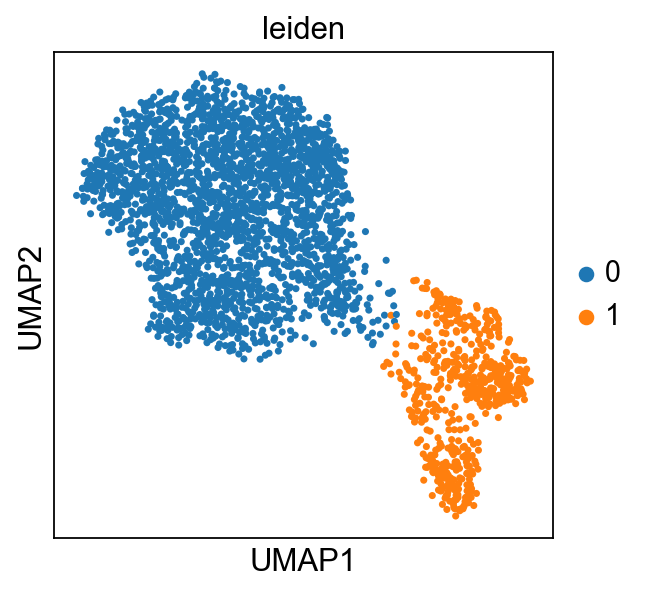

In [40]:
sc.pl.umap(bdata, color=['leiden'], ncols=1)

In [71]:
sc.pl.umap(bdata, color=['leiden', 'Cell_type', 'Csf3r'], ncols=1)

NameError: name 'bdata' is not defined

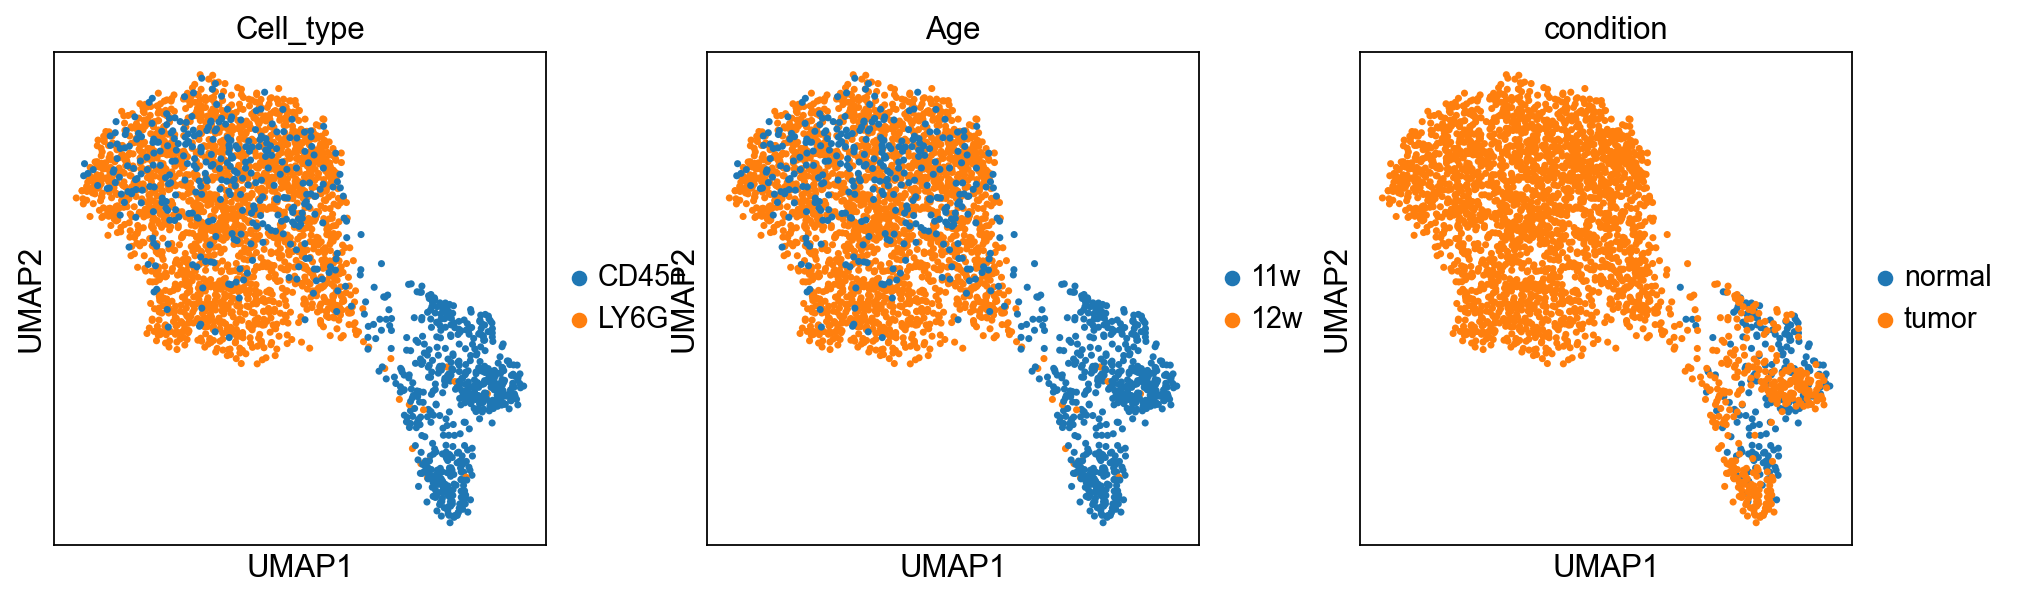

In [41]:
sc.pl.umap(bdata, color=['Cell_type', 'Age', 'condition'], ncols=3)

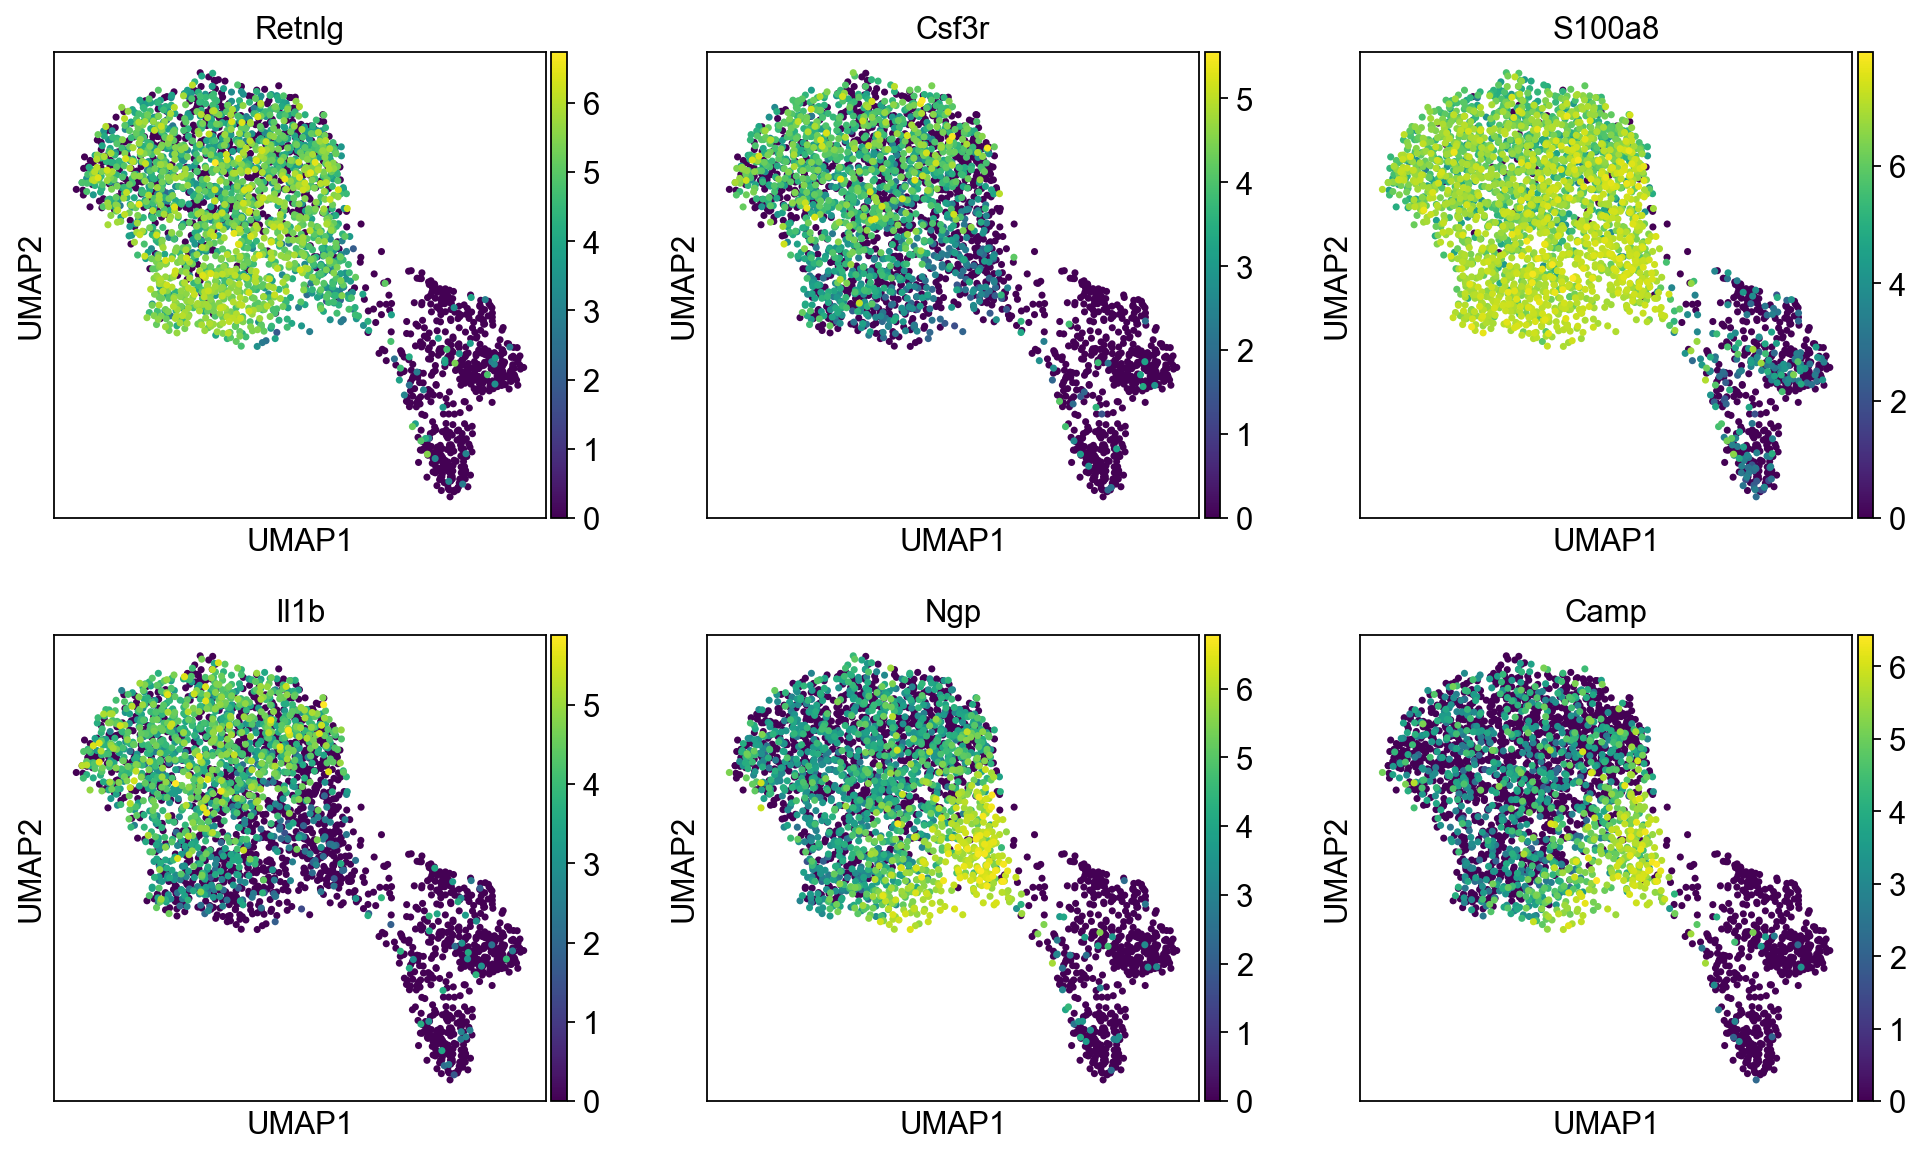

In [42]:
sc.pl.umap(bdata, color=['Retnlg', 'Csf3r', 'S100a8', 'Il1b', 'Ngp', 'Camp'], ncols=3)

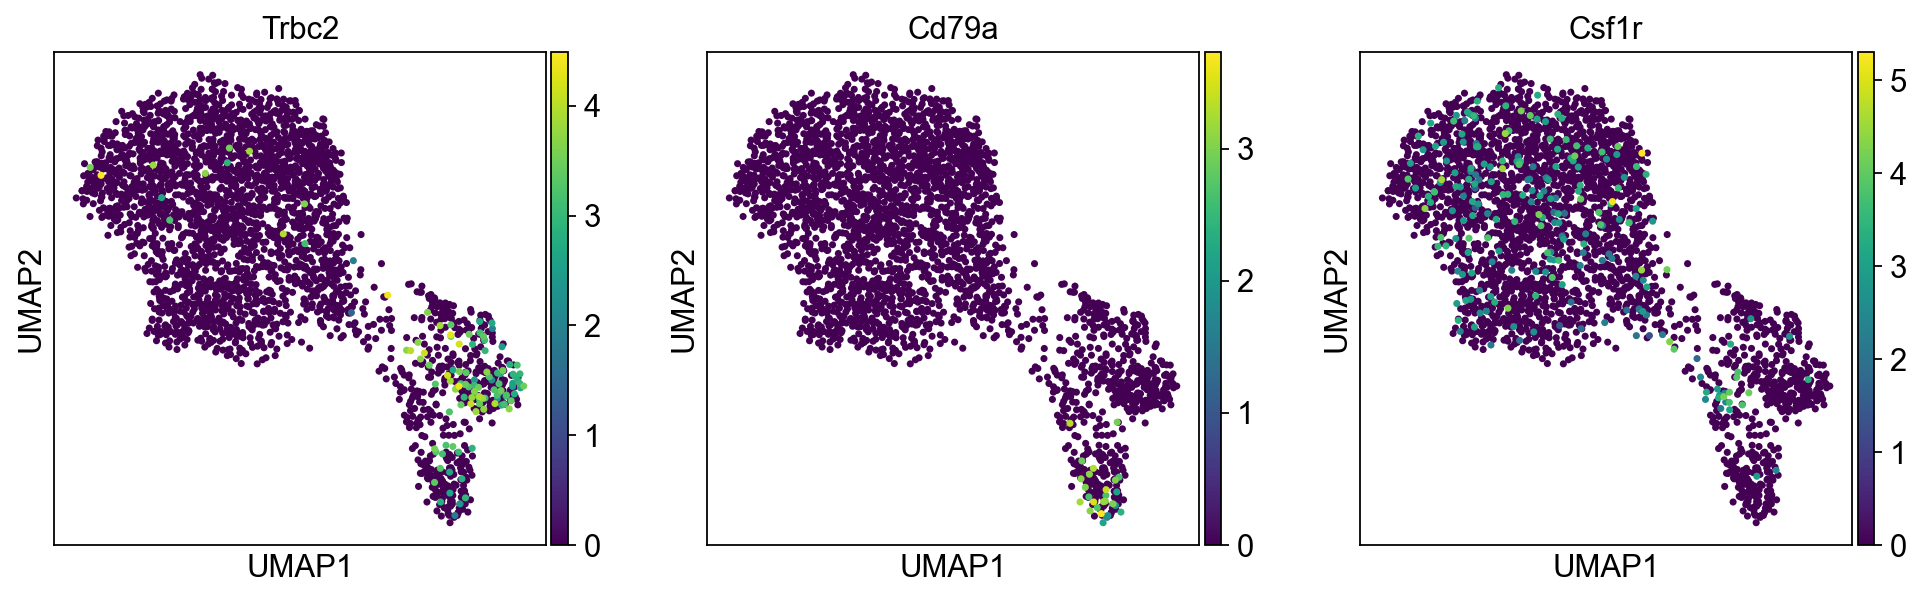

In [43]:
sc.pl.umap(bdata, color=['Trbc2', 'Cd79a', 'Csf1r'], ncols=3)

In [44]:
neutrophils_cellnames = bdata[bdata.obs.leiden.isin(['0'])].obs.index.values

In [45]:
ndata = sc.concat([blood_adata[neutrophils_cellnames], tumor_adata])

In [46]:
ndata.shape

(4159, 30804)

In [47]:
ndata.obs[['Age', 'condition', 'Tissue', 'Cell_type']].value_counts(sort=False)

Age  condition  Tissue            Cell_type
10d  normal     Mammary Gland     CD45+          42
                                  LY6G          103
     tumor      Mammary Gland     CD45+          47
                                  LY6G           19
10w  normal     Mammary Gland     LY6G          119
     tumor      Mammary Gland     LY6G          347
11w  normal     Peripheral Blood  CD45+           3
     tumor      Peripheral Blood  CD45+         356
12w  tumor      Mammary Gland     LY6G          594
                Peripheral Blood  LY6G         2041
8w   tumor      Mammary Gland     LY6G          488
Name: count, dtype: int64

In [58]:
ndata.obs['annots'] = [neut_annots.loc[o,'annot'] if o in neut_annots.index else 'Blood' for o in ndata.obs_names]

In [59]:
ndata.write_h5ad('/mc_disk2/data/h5ads/breast/tumor_blood_neutrophils.h5ad')

... storing 'annots' as categorical


# Rough look

In [59]:
ndata = sc.read_h5ad('/mc_disk2/data/h5ads/breast/tumor_blood_neutrophils.h5ad')

In [60]:
ndata = ndata[ndata.obs.Age.isin(['10w', '11w', '12w'])]

In [61]:
ndata = ndata[ndata.obs.condition.isin(['tumor'])]

In [62]:
ndata = ndata[~ndata.obs.annots.isin(['Cystatin neut', 'Young neut'])]

In [63]:
ndata.obs.annots = ndata.obs.annots.cat.reorder_categories(['Blood','Young TAN', 'TAN1', 'TAN2', 'MHCII neut', 'Neut Ptgs2+'])

In [64]:
sc.pp.filter_genes(ndata, min_cells=3)

filtered out 20305 genes that are detected in less than 3 cells


In [65]:
ndata.obs[['Age', 'condition', 'Tissue', 'Cell_type']].value_counts(sort=False)

Age  condition  Tissue            Cell_type
10w  tumor      Mammary Gland     LY6G          345
11w  tumor      Peripheral Blood  CD45+         356
12w  tumor      Mammary Gland     LY6G          587
                Peripheral Blood  LY6G         2041
Name: count, dtype: int64

In [66]:
ndata.obs[['Tissue']].value_counts(sort=False)

Tissue          
Mammary Gland        932
Peripheral Blood    2397
Name: count, dtype: int64

In [37]:
ndata.shape

(3329, 10499)

In [38]:
ndata.layers['counts'] = ndata.X.copy()

In [39]:
sc.pp.normalize_total(ndata, target_sum=10000)

normalizing counts per cell
    finished (0:00:00)


In [40]:
sc.pp.log1p(ndata)

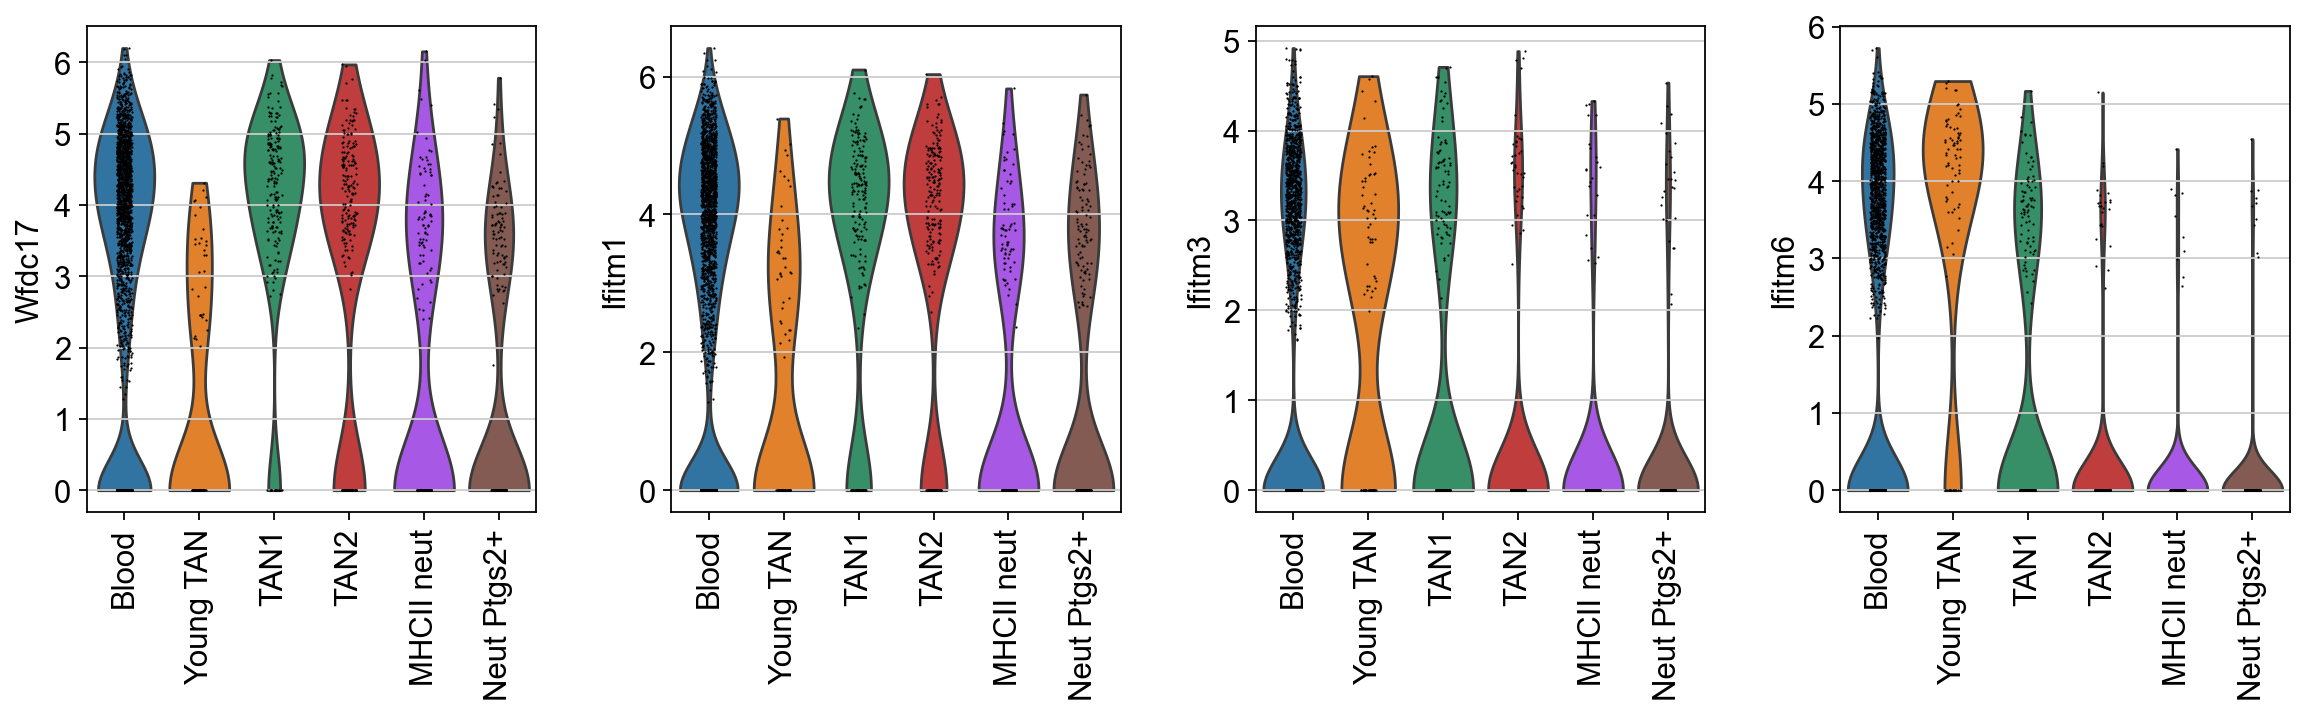

In [41]:
sc.pl.violin(ndata, ['Wfdc17', 'Ifitm1', 'Ifitm3', 'Ifitm6'], groupby='annots', rotation=90)

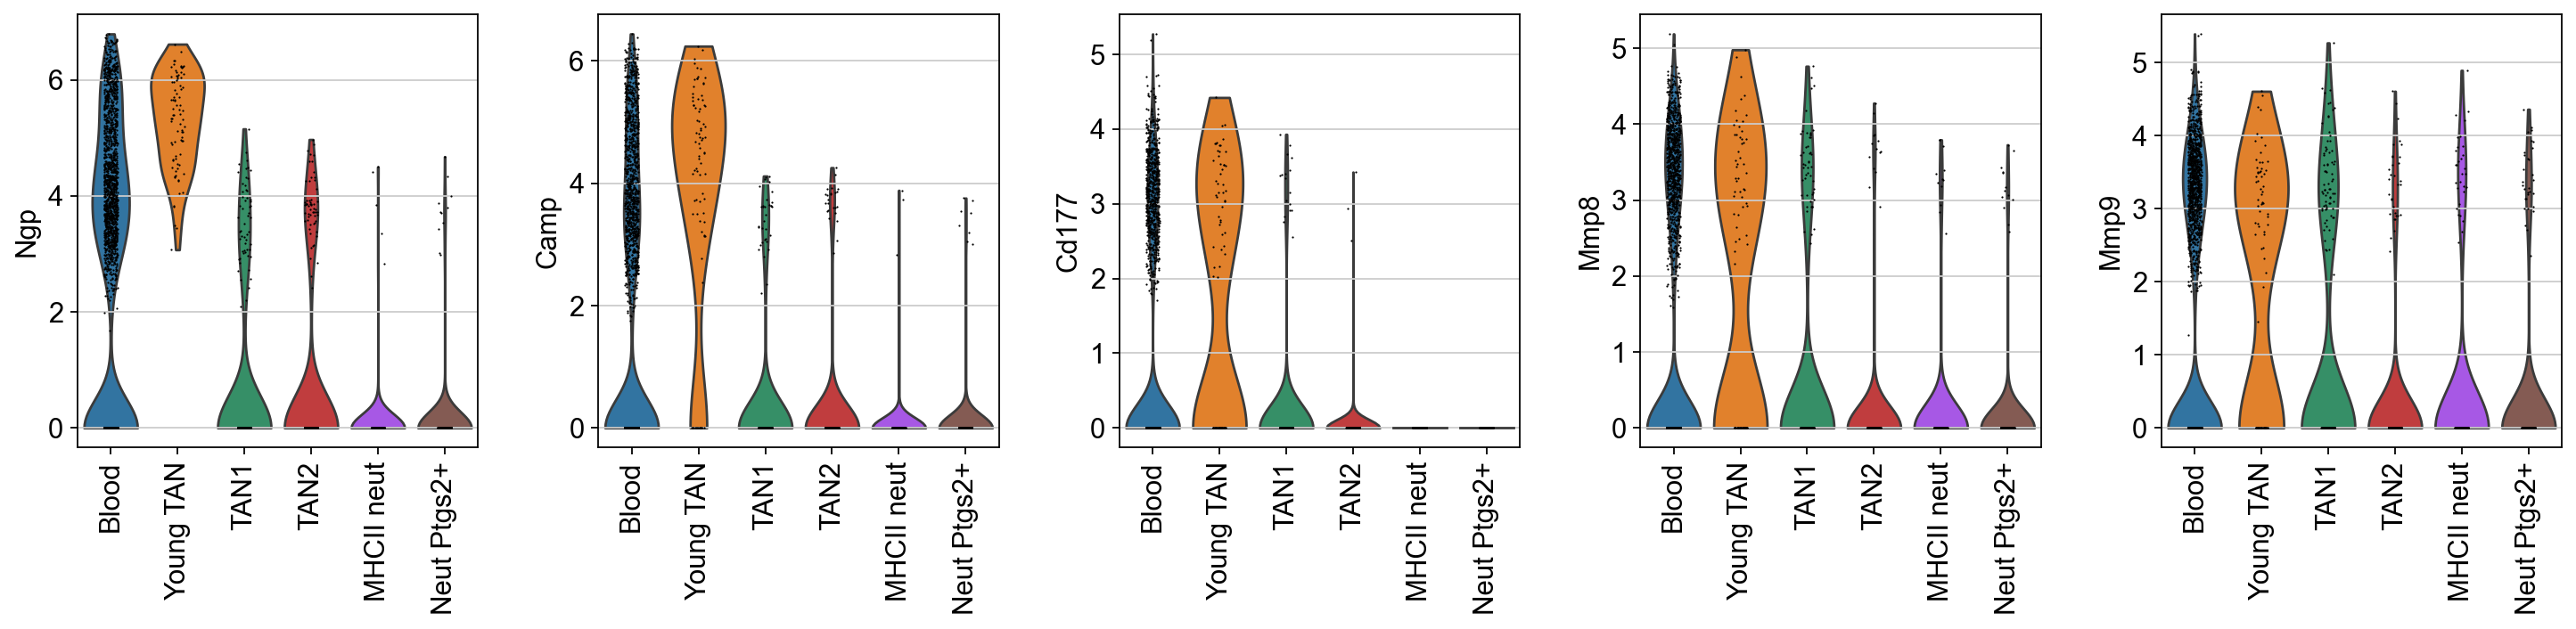

In [42]:
sc.pl.violin(ndata, ['Ngp', 'Camp', 'Cd177', 'Mmp8', 'Mmp9'], groupby='annots', rotation=90)

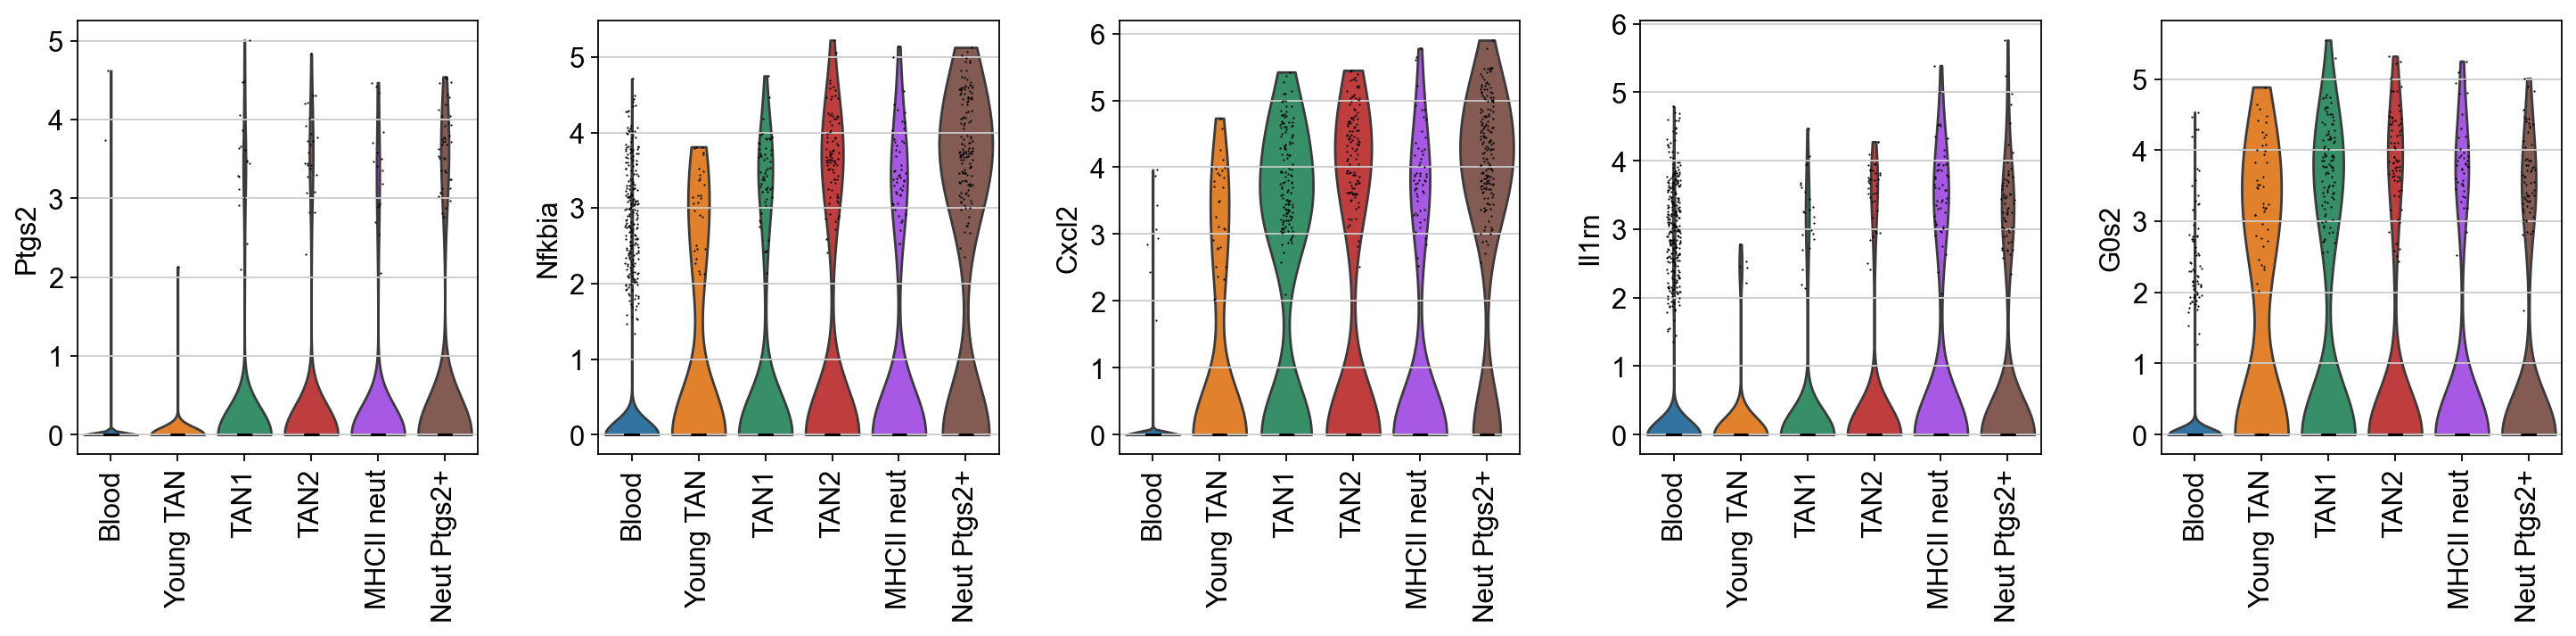

In [43]:
sc.pl.violin(ndata, ['Ptgs2', 'Nfkbia', 'Cxcl2', 'Il1rn', 'G0s2'], groupby='annots', rotation=90)

In [44]:
sc.tl.rank_genes_groups(ndata, groupby='annots')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [45]:
pd.DataFrame(ndata.uns["rank_genes_groups"]["names"][0:25])

Blood Young TAN     TAN1     TAN2 MHCII neut Neut Ptgs2+
0       Ngp       Ngp  mt-Cytb     Il1b       Il1b        Il1b
1      Camp      Lcn2     Il1b   mt-Nd4    mt-Cytb       Cxcl2
2    Ifitm6    S100a8   mt-Nd1  mt-Cytb     mt-Nd1        Cd14
3     Cd177      Lyz2   S100a8   mt-Nd1     mt-Nd4       Dusp1
4    Wfdc21      Camp    Cxcl2     Cd14        Fos       Zfp36
5      Mmp8     Anxa1   Retnlg    Zfp36       Egr1      Nfkbia
6     Rsrp1       Ltf    Dusp1   mt-Nd6       Btg2       Ccrl2
7       Ltf    Wfdc21   mt-Nd4      Fos       Srgn         Fos
8     Gapdh    Retnlg   S100a9    Dusp1      Dusp1      mt-Nd1
9      Actb    Ifitm6     Cd14   mt-Nd2       Cd14     mt-Cytb
10     Lcn2    S100a9   mt-Nd2     Egr1     mt-Nd2        Egr1
11    Ly6a2   mt-Cytb   Wfdc17    Cxcl2       Junb        Srgn
12     Lyz2    S100a6      Fos    Ccrl2     Malat1      Malat1
13   Tmsb4x    mt-Nd1     G0s2     Btg2  Rn18s-rs5        Btg2
14     Cybb      G0s2    Trem1     Srgn    mt-Rnr2      mt-Nd4
15    Adpgk      Cd14     Btg2  mt-Rnr2       Apoe        Junb
16    Anxa1    mt-Nd4   mt-Nd6    Trem1     mt-Nd6      mt-Nd2
17  Arhgdib    mt-Nd2     Srgn     Csn3      Trem1      Csrnp1
18    Ly6c2    mt-Nd6     Csn3      Trf    mt-Rnr1        Pim1
19     Ly6g     Chil3    Zfp36     G0s2      Cxcl2      Nfkbiz
20  Alox5ap     Ly6a2      Osm   Nfkbia       Vmp1     mt-Rnr2
21  Pglyrp1     Cd177  Stfa2l1     Fth1      Resf1       Cebpb
22    G6pdx     G6pdx   Cstdc5  mt-Rnr1      Il1rn       Trib1
23   Retnlg   Arhgdib    Cebpb     Junb      Ccrl2       Nr4a1
24    Rflnb     Ly6c2    Ccrl2    Cebpb      Cebpb    Ppp1r15a

In [46]:
gene_dict = {str(i): [l[i] for l in ndata.uns["rank_genes_groups"]["names"][:10]] 
             for i in ndata.obs.annots.values.categories}

In [47]:
prev_vals = []
for k in gene_dict.keys():
    gene_dict[k] = [i for i in gene_dict[k] if i not in prev_vals and not i[:2] in ["Rp", 'mt', 'Gm']]
    prev_vals += gene_dict[k]

In [48]:
sc.tl.dendrogram(ndata, groupby='annots')

         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_annots']`


In [49]:
ndata.obs['Batch.Set.ID'].value_counts()

Batch.Set.ID
Sandra-PB-neut2    1054
Sandra-PB-neut1     987
sandra-12w-6        346
sandra-10w-6        267
sandra-ctc-1        237
sandra-12w-3        154
Sandra-ctc-2        119
sandra-12w-4         87
Sandra-10w-5         78
Name: count, dtype: int64

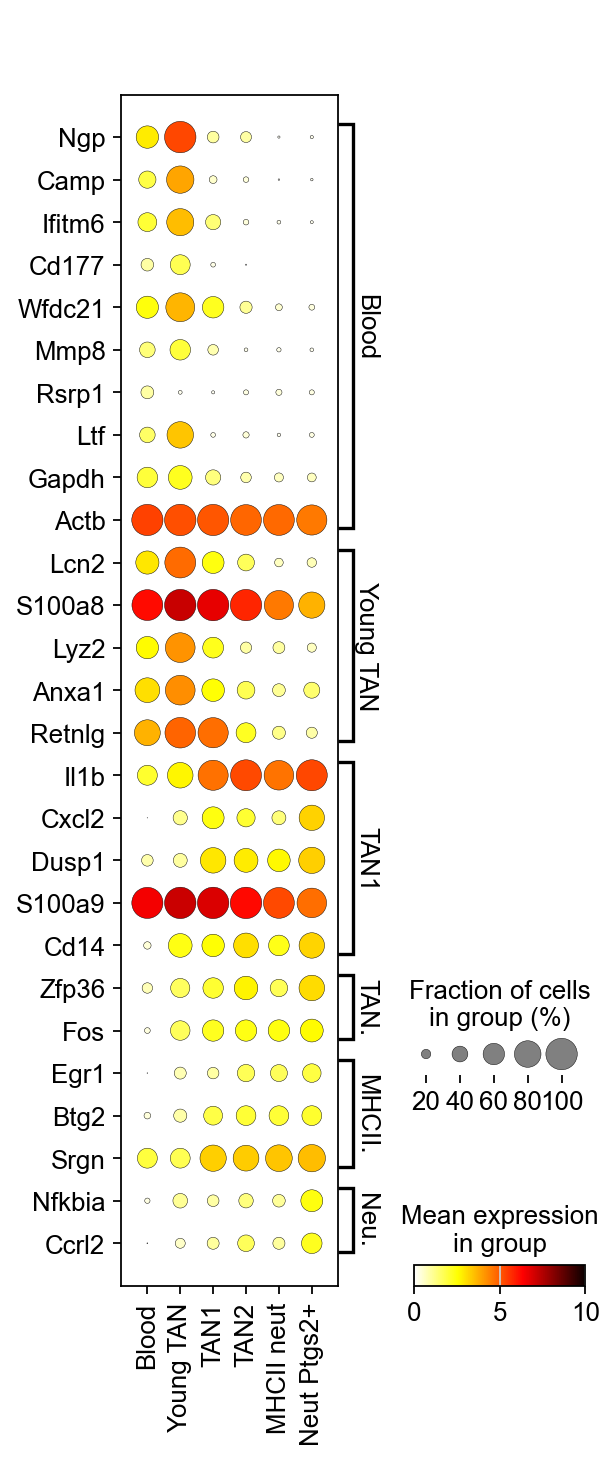

In [50]:
sc.pl.dotplot(ndata, gene_dict, groupby="annots", dendrogram=False, swap_axes=True,
              cmap="hot_r", vmin=0, vmax=10, use_raw=False)

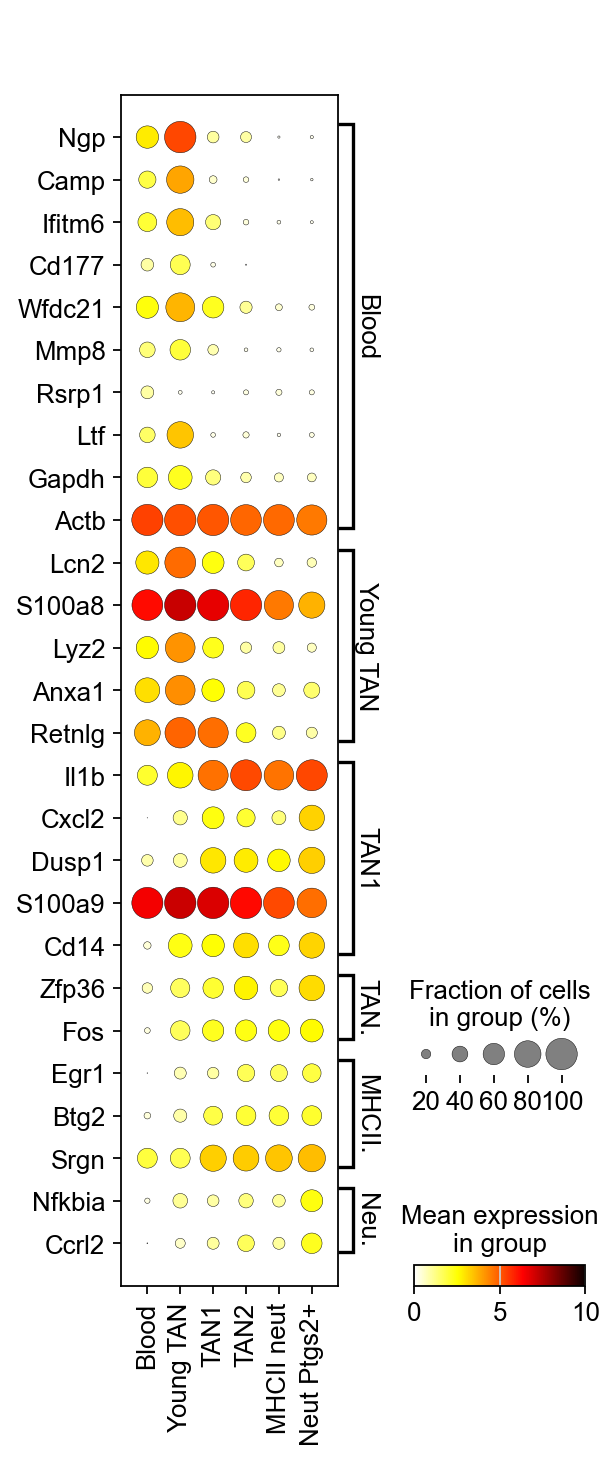

In [51]:
sc.pl.dotplot(ndata, gene_dict, groupby="annots", dendrogram=False, swap_axes=True,
              cmap="hot_r", vmin=0, vmax=10, use_raw=False)

In [52]:
neut_genes = ['Ngp', 'Camp', 'Cd177', 'Mmp8', 'Ifitm6', 'Ltf', 'Ifitm3', 
              'Wfdc21', 'Lcn2', 'Anxa1', 'Retnlg', 
              'Wfdc17', 'Ifitm1', 
              'Srgn', 'Il1b', 'Cd14', 'Dusp1', 'Cxcl2', 'Trem1', 'Btg2', 'Egr1', 'Nfkbia', 'Ccrl2', 'Il1rn', 'Il1r2', 
              'Ptgs2']

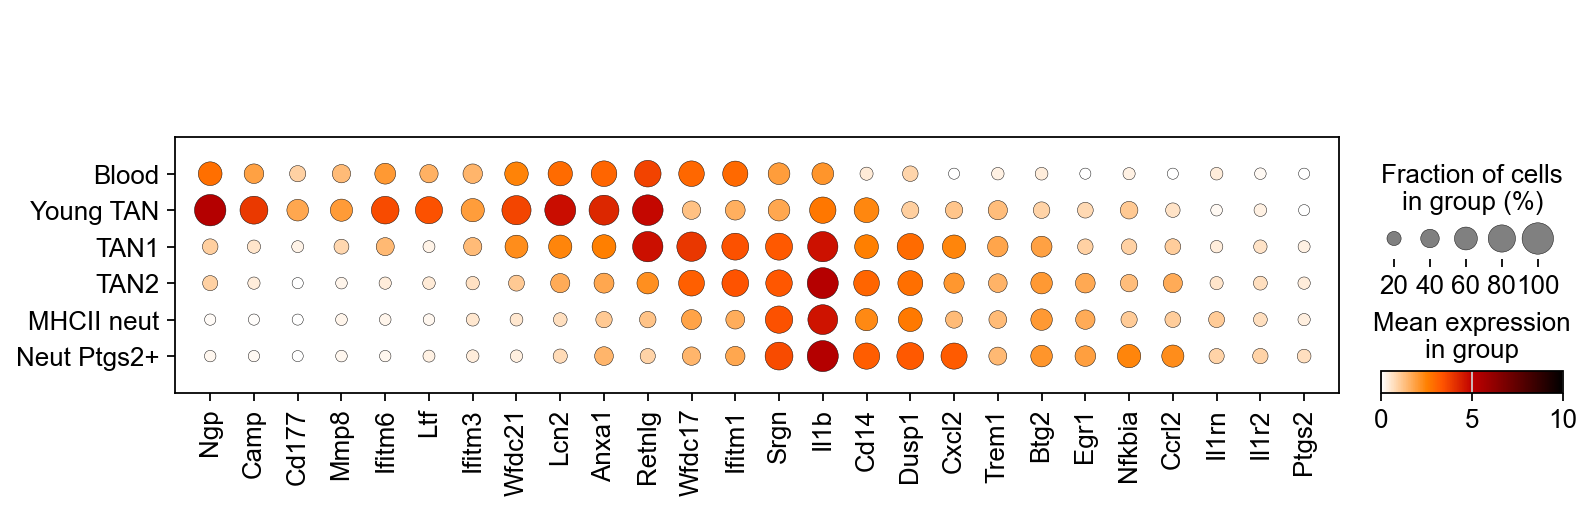

In [53]:
sc.pl.dotplot(ndata, neut_genes, groupby="annots", dendrogram=False, swap_axes=False, smallest_dot=25, cmap='gist_heat_r',
              vmin=0, vmax=10, use_raw=False, save="tumor_blood_dotplot.pdf")

In [73]:
neut_genes

['Ngp',
 'Camp',
 'Cd177',
 'Mmp8',
 'Ifitm6',
 'Ltf',
 'Ifitm3',
 'Wfdc21',
 'Lcn2',
 'Anxa1',
 'Retnlg',
 'Wfdc17',
 'Ifitm1',
 'Srgn',
 'Il1b',
 'Cd14',
 'Dusp1',
 'Cxcl2',
 'Trem1',
 'Btg2',
 'Egr1',
 'Nfkbia',
 'Ccrl2',
 'Il1rn',
 'Il1r2',
 'Ptgs2']

In [74]:
import decoupler as dc

In [75]:
dc.__version__

'1.6.0'

In [81]:
pdata = dc.get_pseudobulk(
    ndata,
    sample_col='Batch.Set.ID',
    groups_col=['Tissue', 'Age'],
    layer='counts',
    mode='sum',
    min_cells=20,
    min_counts=100
)
pdata


AnnData object with n_obs × n_vars = 9 × 10499
    obs: 'Seq.Batch.ID', 'Date of sequencing', 'Batch.Set.ID', 'Owner', 'Date of sort', 'Plate ID (15 characters, no _/+)', 'Empty_well', 'Species', 'Genome', 'Strain', 'condition', 'Time_point', 'Tissue', 'Age', 'Cell_type', 'PIC_seq', 'comment', 'Replicate', 'Tissue_Age', 'psbulk_n_cells', 'psbulk_counts'
    var: 'n_cells'
    layers: 'psbulk_props'

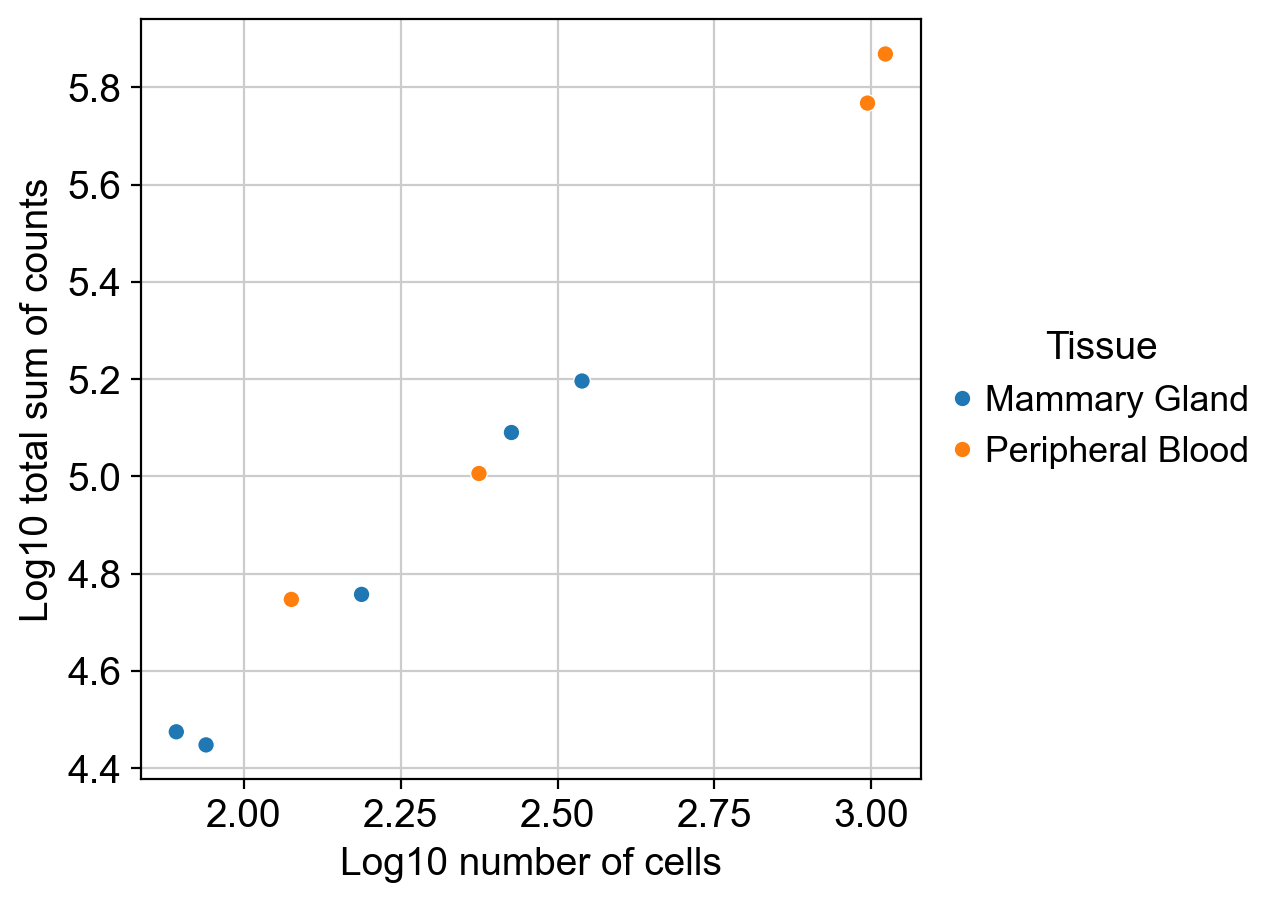

In [82]:
dc.plot_psbulk_samples(pdata, groupby='Tissue', figsize=(5, 5))

In [83]:
pdata.obs

Seq.Batch.ID Date of sequencing  \
Sandra-10w-5_Mammary Gland_10w              SB007         22/12/2022   
sandra-10w-6_Mammary Gland_10w              SB015         18/06/2024   
sandra-12w-3_Mammary Gland_12w              SB009         21/05/2023   
sandra-12w-4_Mammary Gland_12w              SB009         21/05/2023   
sandra-12w-6_Mammary Gland_12w              SB012         14/12/2023   
Sandra-ctc-2_Peripheral Blood_11w           SB007         22/12/2022   
sandra-ctc-1_Peripheral Blood_11w           SB006         18/09/2022   
Sandra-PB-neut1_Peripheral Blood_12w        SB015         18/06/2024   
Sandra-PB-neut2_Peripheral Blood_12w        SB015         18/06/2024   

                                         Batch.Set.ID   Owner Date of sort  \
Sandra-10w-5_Mammary Gland_10w           Sandra-10w-5  Sandra   03/11/2022   
sandra-10w-6_Mammary Gland_10w           sandra-10w-6  Sandra   05/06/2024   
sandra-12w-3_Mammary Gland_12w           sandra-12w-3  Sandra   16/04/2023   
sandra-12w-4_Mammary Gland_12w           sandra-12w-4  Sandra   23/04/2023   
sandra-12w-6_Mammary Gland_12w           sandra-12w-6  Sandra   29/10/2023   
Sandra-ctc-2_Peripheral Blood_11w        Sandra-ctc-2  Sandra   27/10/2022   
sandra-ctc-1_Peripheral Blood_11w        sandra-ctc-1  Sandra   23/06/2022   
Sandra-PB-neut1_Peripheral Blood_12w  Sandra-PB-neut1  Sandra   21/04/2024   
Sandra-PB-neut2_Peripheral Blood_12w  Sandra-PB-neut2  Sandra   14/05/2024   

                                     Plate ID (15 characters, no _/+)  \
Sandra-10w-5_Mammary Gland_10w                                          
sandra-10w-6_Mammary Gland_10w                                          
sandra-12w-3_Mammary Gland_12w                                          
sandra-12w-4_Mammary Gland_12w                                          
sandra-12w-6_Mammary Gland_12w                                          
Sandra-ctc-2_Peripheral Blood_11w                                       
sandra-ctc-1_Peripheral Blood_11w                                       
Sandra-PB-neut1_Peripheral Blood_12w                                    
Sandra-PB-neut2_Peripheral Blood_12w                                    

                                     Empty_well Species  Genome Strain  ...  \
Sandra-10w-5_Mammary Gland_10w            False   Mouse  Grcm39         ...   
sandra-10w-6_Mammary Gland_10w            False   Mouse                 ...   
sandra-12w-3_Mammary Gland_12w            False   Mouse  Grcm39         ...   
sandra-12w-4_Mammary Gland_12w            False   Mouse  Grcm39         ...   
sandra-12w-6_Mammary Gland_12w            False   Mouse  Grcm39   PyMT  ...   
Sandra-ctc-2_Peripheral Blood_11w         False   Mouse  Grcm39   PyMT  ...   
sandra-ctc-1_Peripheral Blood_11w         False   Mouse  Grcm39   PyMT  ...   
Sandra-PB-neut1_Peripheral Blood_12w      False   Mouse           PyMT  ...   
Sandra-PB-neut2_Peripheral Blood_12w      False   Mouse           PyMT  ...   

                                     Time_point            Tissue  Age  \
Sandra-10w-5_Mammary Gland_10w                      Mammary Gland  10w   
sandra-10w-6_Mammary Gland_10w              10w     Mammary Gland  10w   
sandra-12w-3_Mammary Gland_12w                      Mammary Gland  12w   
sandra-12w-4_Mammary Gland_12w                      Mammary Gland  12w   
sandra-12w-6_Mammary Gland_12w                      Mammary Gland  12w   
Sandra-ctc-2_Peripheral Blood_11w                Peripheral Blood  11w   
sandra-ctc-1_Peripheral Blood_11w           11w  Peripheral Blood  11w   
Sandra-PB-neut1_Peripheral Blood_12w        12w  Peripheral Blood  12w   
Sandra-PB-neut2_Peripheral Blood_12w        12w  Peripheral Blood  12w   

                                     Cell_type PIC_seq comment Replicate  \
Sandra-10w-5_Mammary Gland_10w            LY6G                         5   
sandra-10w-6_Mammary Gland_10w            LY6G                         6   
sandra-12w-3_Mammary Gland_12w            LY

In [84]:
pp_pdata = pdata.copy()
sc.pp.normalize_total(pp_pdata, target_sum=1e3)
sc.pp.log1p(pp_pdata)
sc.pp.scale(pp_pdata, max_value=10)
sc.tl.pca(pp_pdata)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=8
    finished (0:00:00)


... storing 'Seq.Batch.ID' as categorical
... storing 'Date of sequencing' as categorical
... storing 'Owner' as categorical
... storing 'Plate ID (15 characters, no _/+)' as categorical
... storing 'Species' as categorical
... storing 'Genome' as categorical
... storing 'Strain' as categorical
... storing 'condition' as categorical
... storing 'Time_point' as categorical
... storing 'Tissue' as categorical
... storing 'Age' as categorical
... storing 'Cell_type' as categorical
... storing 'PIC_seq' as categorical
... storing 'comment' as categorical
... storing 'Replicate' as categorical
... storing 'Tissue_Age' as categorical


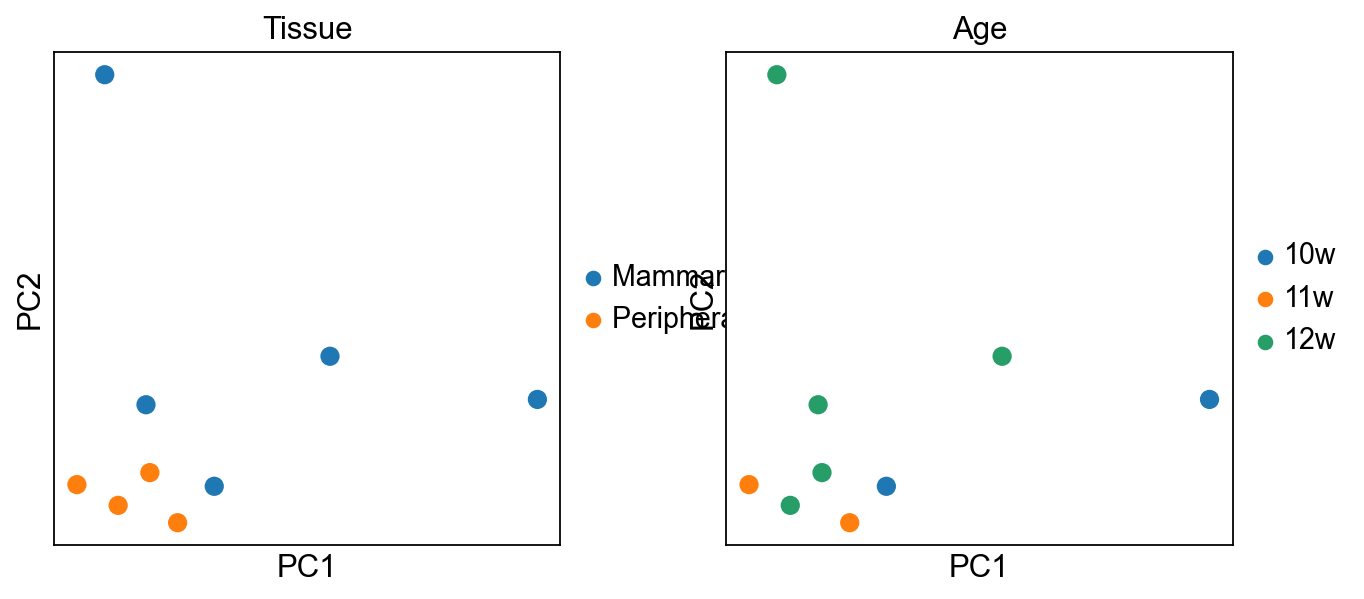

In [85]:
sc.pl.pca(pp_pdata, color=['Tissue', 'Age'], ncols=2, show=True, size=300)

In [86]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [87]:
import pydeseq2

In [88]:
pydeseq2.__version__

'0.4.4'

In [89]:
dds = DeseqDataSet(
    adata=pdata,
    design_factors=['Tissue'],
    #ref_level=["Depletion", "Isotype"],
    refit_cooks=True,
    #n_cpus=8,
)


In [90]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 6.03 seconds.

Fitting dispersion trend curve...
... done in 0.33 seconds.

Fitting MAP dispersions...
... done in 6.72 seconds.

Fitting LFCs...
... done in 6.56 seconds.

Refitting 0 outliers.



In [91]:
stat_res = DeseqStats(dds, contrast=["Tissue", "Mammary Gland", "Peripheral Blood"])

In [92]:
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: Tissue Mammary Gland vs Peripheral Blood
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene                                                                       
0610009B22Rik     0.731226        1.073231  1.512377  0.709632  0.477932   
0610009L18Rik     0.163867        0.581583  2.614486  0.222447  0.823966   
0610012G03Rik     1.090765       -2.004724  1.716798 -1.167711  0.242923   
0610030E20Rik     7.685254       -0.631665  0.540531 -1.168601  0.242564   
0610040J01Rik     2.853234       -0.036377  0.844910 -0.043054  0.965658   
...                    ...             ...       ...       ...       ...   
mt-Rnr2        4666.147461        0.656034  0.224179  2.926386  0.003429   
mt-Tc             0.322964       -0.792475  2.649000 -0.299160  0.764818   
mt-Te             3.559997        2.056840  2.800623  0.734422  0.462691   
mt-Tp             1.075117        2.870829  1.689413  1.699306  0.089262   
mt-Ts1   

... done in 5.96 seconds.



In [93]:
res_df = stat_res.results_df

In [94]:
res_df.loc[neut_genes]

baseMean  log2FoldChange     lfcSE       stat         pvalue  \
gene                                                                      
Ngp      811.485596       -1.818084  1.694870  -1.072698   2.834065e-01   
Camp     404.447815       -1.806853  2.092484  -0.863497   3.878643e-01   
Cd177     62.252808       -2.163893  1.480442  -1.461653   1.438363e-01   
Mmp8     109.115921       -1.719697  0.787710  -2.183160   2.902400e-02   
Ifitm6   279.725281       -1.590173  1.115716  -1.425248   1.540854e-01   
Ltf      267.868011       -1.806741  1.623561  -1.112826   2.657831e-01   
Ifitm3   118.418129       -0.891576  0.582237  -1.531294   1.256967e-01   
Wfdc21   289.118744       -1.060986  0.652944  -1.624927   1.041781e-01   
Lcn2     598.418701       -1.310928  0.855027  -1.533201   1.252263e-01   
Anxa1    487.864807       -0.936998  0.542183  -1.728197   8.395291e-02   
Retnlg  1117.394165       -0.651311  0.655761  -0.993213   3.206060e-01   
Wfdc17   559.246765        0.153620  0.442249   0.347361   7.283202e-01   
Ifitm1   525.266846        0.070692  0.433202   0.163185   8.703728e-01   
Srgn     472.353149        1.513811  0.270579   5.594701   2.210025e-08   
Il1b    1297.017700        2.746613  0.335283   8.191928   2.570754e-16   
Cd14     286.565277        3.746880  0.141126  26.549947  2.571822e-155   
Dusp1    301.908691        2.435854  0.294634   8.267379   1.369364e-16   
Cxcl2    230.656769        7.316335  1.045054   7.000918   2.542916e-12   
Trem1    108.397697        2.940559  0.242531  12.124478   7.835746e-34   
Btg2     159.935226        2.673767  0.435678   6.137031   8.407808e-10   
Egr1     114.611603        5.307258  0.871765   6.087948   1.143672e-09   
Nfkbia   110.577301        2.886987  0.431543   6.689910   2.233079e-11   
Ccrl2    110.808708        6.255291  0.621320  10.067750   7.671260e-24   
Il1rn     53.585606        1.432646  0.336601   4.256211   2.079201e-05   
Il1r2     44.119835        2.751274  0.402458   6.836171   8.133800e-12   
Ptgs2     21.493090        7.106745  0.892410   7.963542   1.671839e-15   

                 padj  
gene                   
Ngp      7.916775e-01  
Camp     8.452347e-01  
Cd177    6.501498e-01  
Mmp8     3.418383e-01  
Ifitm6   6.663249e-01  
Ltf      7.748481e-01  
Ifitm3   6.276012e-01  
Wfdc21   5.959210e-01  
Lcn2     6.276012e-01  
Anxa1    5.427293e-01  
Retnlg   8.158490e-01  
Wfdc17   9.504742e-01  
Ifitm1   9.849000e-01  
Srgn     3.063434e-06  
Il1b     1.263409e-13  
Cd14    1.390327e-151  
Dusp1    8.225316e-14  
Cxcl2    7.334040e-10  
Trem1    2.118002e-30  
Btg2     1.515087e-07  
Egr1     1.932091e-07  
Nfkbia   5.030009e-09  
Ccrl2    8.294167e-21  
Il1rn    1.652964e-03  
Il1r2    1.998697e-09  
Ptgs2    6.952277e-13

In [381]:
res_df[(res_df.padj < 0.001) & (res_df.log2FoldChange > 2)].index

Index(['Acod1', 'Bcl2a1b', 'Btg2', 'Ccl3', 'Ccrl2', 'Cd14', 'Cdkn1a', 'Cebpb',
       'Clec4n', 'Coq10b', 'Csn3', 'Csrnp1', 'Cxcl2', 'Dusp1', 'Dusp5', 'Egr1',
       'Fos', 'Fosb', 'G0s2', 'Gns', 'Gpr35', 'Ier3', 'Il1b', 'Il1r2', 'Isg15',
       'Lalba', 'Nfkbia', 'Nfkbid', 'Nfkbiz', 'Nr4a1', 'Osm', 'P4hb', 'Pde4b',
       'Ptgs2', 'Spp1', 'Tgm2', 'Tnfaip3', 'Trem1', 'Trib1', 'Vegfa', 'Zfp36',
       'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6'],
      dtype='object', name='gene')

In [238]:
def sum_by(adata: ad.AnnData, col: str) -> ad.AnnData:
    adata.strings_to_categoricals()
    assert pd.api.types.is_categorical_dtype(adata.obs[col])

    indicator = pd.get_dummies(adata.obs[col])

    return ad.AnnData(
        indicator.values.T @ adata.X,
        var=adata.var,
        obs=pd.DataFrame(index=indicator.columns)
    )


In [239]:
lfc_adata = sum_by(pdata, 'Tissue')

... storing 'Seq.Batch.ID' as categorical
... storing 'Date of sequencing' as categorical
... storing 'Owner' as categorical
... storing 'Plate ID (15 characters, no _/+)' as categorical
... storing 'Species' as categorical
... storing 'Genome' as categorical
... storing 'Strain' as categorical
... storing 'condition' as categorical
... storing 'Time_point' as categorical
... storing 'Tissue' as categorical
... storing 'Age' as categorical
... storing 'Cell_type' as categorical
... storing 'PIC_seq' as categorical
... storing 'comment' as categorical
... storing 'Replicate' as categorical
... storing 'Tissue_Age' as categorical


In [240]:
sc.pp.normalize_total(lfc_adata, target_sum=1e5)

normalizing counts per cell
    finished (0:00:00)


In [241]:
sc.pp.log1p(lfc_adata)

In [242]:
reg = 1

In [243]:
new_lfc = np.log2((lfc_adata.X[0] + reg) / (lfc_adata.X[1] + reg))

In [244]:
(lfc_adata.var_names == res_df.index).all()

True

In [337]:
res_df['new_lfc'] = new_lfc

In [338]:
res_df['new_padj'] = [1e-15 if p < 1e-15 else p for p in res_df.padj]

In [362]:
tissue_dges = res_df.index[(res_df.padj < 0.05) & (res_df.new_lfc > 0)]

In [363]:
blood_dges = res_df.index[(res_df.padj < 0.05) & (res_df.new_lfc < 0)]

In [339]:
plt_genes = ['Acod1',
             'Ap3d1',
             'Apoe',
             'Aqp5',
             'Arf4',
             'Atf3',
             'Atp6ap2',
             'Birc3',
             'Btg2',
             'Car6',
             'Ccl3',
             'Ccr1',
             'Ccrl2',
             'Cd14',
             'Cebpb',
             'Clec4e',
             'Clec4n',
             'Coq10b',
             'Csf1',
             'Csrnp1',
             'Cxcl2',
             'Cxcl3',
             'Ddx3x',
             'Egr1',
             'Egr2',
             'Emd',
             'Ets2',
             'Folr1',
             'Fth1',
             'G0s2',
             'Gabpb1',
             'Gata3',
             'Gns',
             'Gpr35',
             'Hcar2',
             'Ier2',
             'Ier3',
             'Igfbp5',
             'Il10ra',
             'Il1b',
             'Il1r2',
             'Il1rn',
             'Isg15',
             'Kctd12',
             'Klf2',
             'Map3k8',
             'Marcksl1',
             'Med21',
             'Mrpl52',
             'Mt1',
             'Naa10',
             'Ndel1',
             'Nfib',
             'Nfil3',
             'Nfkbia',
             'Nfkbid',
             'Nfkbiz',
             'Nop58',
             'Nr4a1',
             'Osm',
             'P4hb',
             'Pde4b',
             'Per1',
             'Phlda1',
             'Pim1',
             'Plet1',
             'Plk3',
             'Pnrc1',
             'Prdx2',
             'Psmc6',
             'Ptgs2',
             'Rheb',
             'Scarb2',
             'Selenon',
             'Serbp1',
             'Snrpd2',
             'Socs3',
             'Sox4',
             'Sparc',
             'Spp1',
             'Srgn',
             'Tasl',
             'Tgm2',
             'Thap6',
             'Thrsp',
             'Tnfaip3',
             'Trem1',
             'Trf',
             'Trib1',
             'Uqcc3',
             'Vegfa',
             'Anxa2',
             'Ccnd3',
             'Cox7a2l',
             'Gda',
             'Gpsm3',
             'Il18rap',
             'Kif21b',
             'Max',
             'Myo1f',
             'Nfe2',
             'Rnf144a',
             'Rsrp1',
             'S100a11',
             'Siglece',
             'Slpi',
             'Taldo1',
             'Vim',
             'Ywhaz']

In [396]:
plt_genes = ['Btg2',
             'Ccl3',
             'Ccrl2',
             'Cd14',
             'Cxcl2',
             'Cxcl3',
             'G0s2',
             'Ier3',
             'Igfbp5',
             'Il1b',
             'Il1r2',
             'Il1rn',
             'Isg15',
             'Nfkbia',
             'Nfkbid',
             'Nfkbiz',
             'Nr4a1',
             'Osm',
             'Ptgs2',
             'Spp1',
             'Tnfaip3',
             'Trem1',
             'Vegfa',
             'Ccnd3',
            'Nfe2',
            'Rsrp1',
            'Vim',
            'Ywhaz']

In [397]:
len(plt_genes)

28

In [449]:
res_df.padj = -np.log10(res_df.padj)

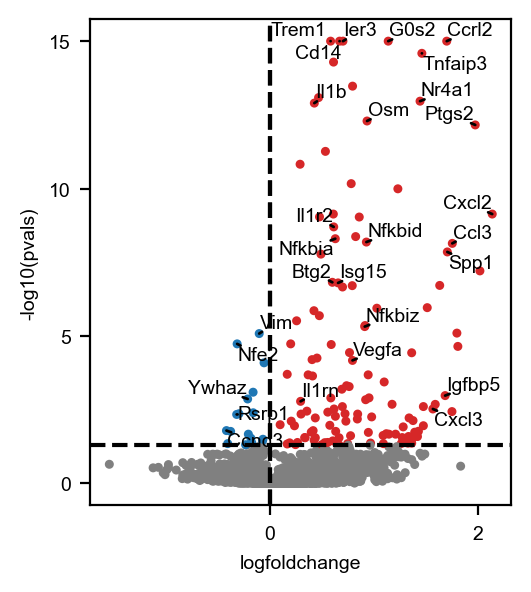

In [450]:
pv = plot_volcano_df(
    res_df,
    x='new_lfc',
    y='new_padj',
    manual_genes=plt_genes,
    sign_thr=0.05,
    lFCs_thr=0,
    manual_fontsize=7,
    manual_dotsize=5,
    figsize=(2.7, 3.2),
    return_fig=True
    #save="revision_figs/tumor_blood_volcano.pdf"
)
plt.grid(False)
plt.savefig("revision_figs/tumor_blood_volcano.pdf")

In [413]:
padjl = res_df.padj

In [416]:
padjl = padjl[~np.isnan(padjl)]

In [444]:
min(-np.log10(-np.log10(padjl)))

-2.178565130213491

<Axes: xlabel='new_lfc', ylabel='padj'>

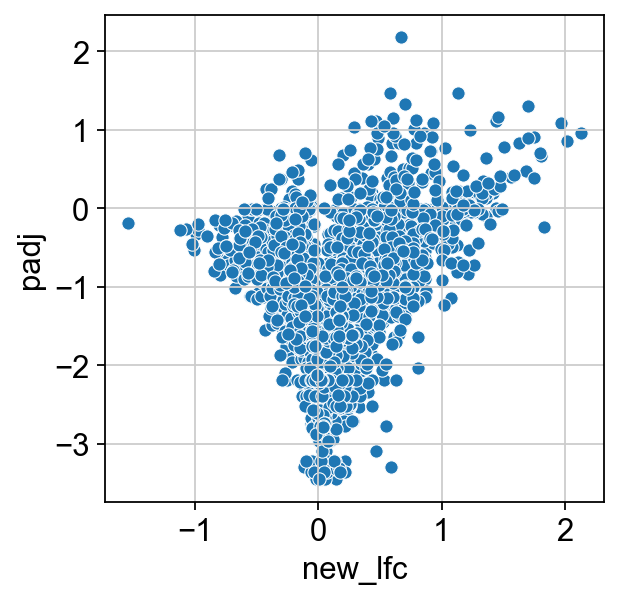

In [447]:
sb.scatterplot(x=res_df['new_lfc'] , y=np.log10(-np.log10(padjl)))

In [431]:
min(-np.log(-np.log(1)))

TypeError: 'numpy.float64' object is not iterable

In [434]:
min(-np.log10(-np.log10(padjl)))

-2.178565130213491

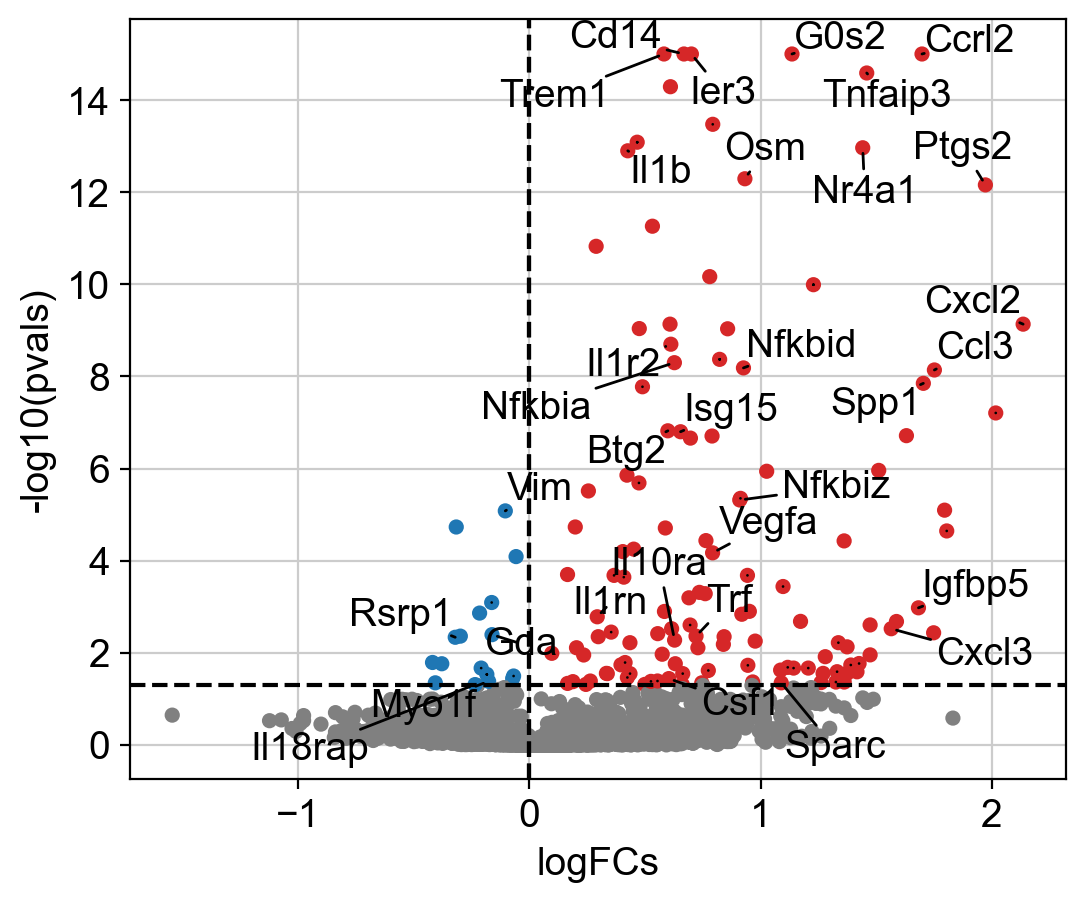

In [253]:
dc.plot_volcano_df(
    res_df_altered,
    x='new_lfc',
    y='new_padj',
    top=1000,
    sign_thr=0.05,
    lFCs_thr=0,
    figsize=(6, 5),
    save="revision_figs/tumor_blood_volcano.png"
)

In [1031]:
dc.plot_volcano_df(
    res_df_altered,
    x='new_lfc',
    y='new_padj',
    top=0,
    sign_thr=0.05,
    lFCs_thr=0,
    figsize=(6, 5),
    dpi=1200,
    save="revision_figs/tumor_blood_volcano_blank.png"
)

In [364]:
sc.tl.score_genes(ndata, tissue_dges, score_name='Tumor')

computing score 'Tumor'
    finished: added
    'Tumor', score of gene set (adata.obs).
    686 total control genes are used. (0:00:00)


In [365]:
sc.tl.score_genes(ndata, blood_dges, score_name='Blood')

computing score 'Blood'
    finished: added
    'Blood', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)


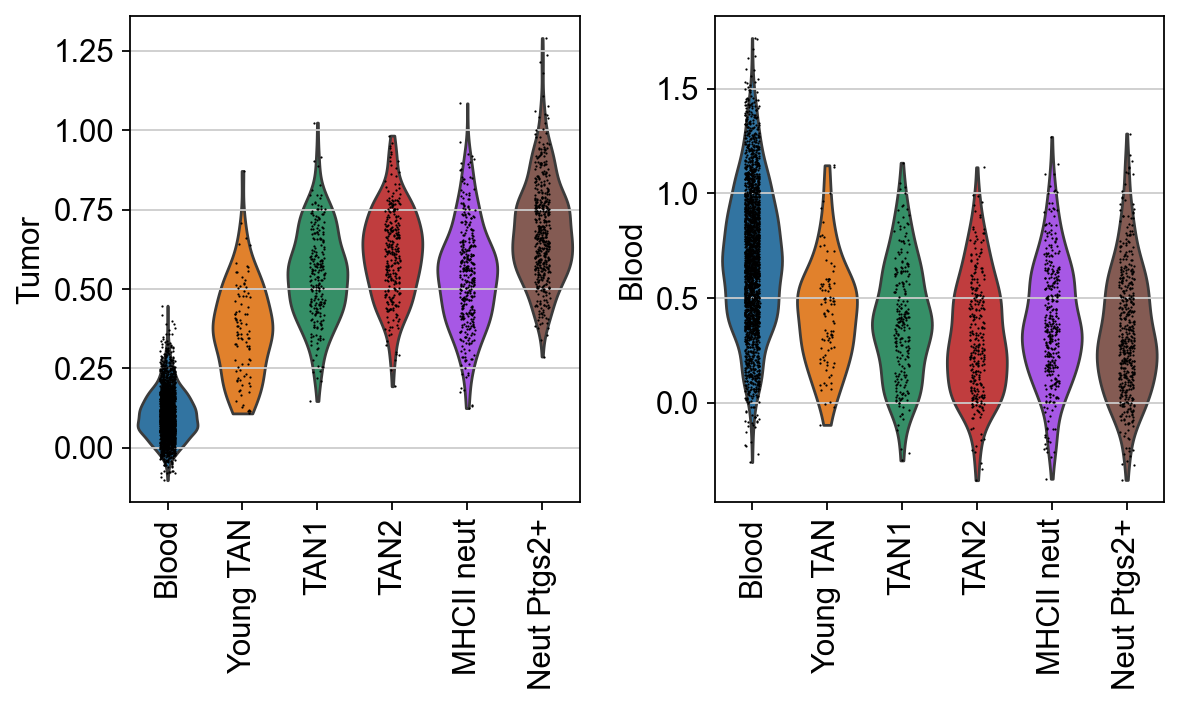

In [367]:
sc.pl.violin(ndata, ['Tumor', 'Blood'], groupby='annots', rotation=90)